In [8]:
#content of distmesh.py
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import Delaunay
from scipy import sparse

# input arguments
#      fd:        Distance function d(x,y)
#      fh:        Scaled edge length function h(x,y)
#      h0:        Initial edge length
#      bbox:      Bounding box [xmin,ymin; xmax,ymax] MASHA: [xmin,xmax,ymin,ymax]
#      pfix:      Fixed node positions (NFIXx2)

# output
#      pts:         Node positions (Nx2)
#      tri:         Triangle indices (NTx3)

def huniform(p):
    m,n = np.shape(p)
    return np.ones((m,1))

def ddiff(d1,d2):
    return np.maximum(d1,-d2)

def dcircle(p,xc,yc,r):
    return np.sqrt((p[:,0]-xc)**2+(p[:,1]-yc)**2)-r

def dellipse(p,xc,yc,rx,ry):
    return np.sqrt(((p[:,0]-xc)**2)/rx**2+((p[:,1]-yc)**2)/ry**2)-1

def drectangle(p,x1,x2,y1,y2):
    d1 = np.minimum(-y1+p[:,1],y2-p[:,1])
    d2 = np.minimum(d1,-x1+p[:,0])
    return -np.minimum(d2,x2-p[:,0])

def dintersect(d1,d2):
    return np.maximum(d1,d2)

def dunion(d1,d2):
    return np.minimum(d1,d2)

def dline(p,x1,y1,x2,y2):
    # signed distance from point p to line through (x1,y1) and  (x2,y2)
    # normal vector to the line
    nx = y1-y2
    ny = x2-x1
    nn = np.sqrt(nx*nx+ny*ny)
    # return (p-(x1,x2))*n/||n||
    return -((p[:,0]-x1)*nx+(p[:,1]-y1)*ny)/nn

def dtriangle(p,x1,y1,x2,y2,x3,y3):
    return np.maximum(dline(p,x1,y1,x2,y2),np.maximum(dline(p,x2,y2,x3,y3),dline(p,x3,y3,x1,y1)))

def triarea(pts,tri):
    # calculates areas of mesh triangles
    # p = [x_vec,y_vec]
    # tri = [ind0,ind1,ind2]
    d12 = pts[tri[:,1],:]-pts[tri[:,0],:]
    d13 = pts[tri[:,2],:]-pts[tri[:,0],:]
    A = d12[:,0]*d13[:,1]-d12[:,1]*d13[:,0]
    return A

def fixmesh(pts,tri):
    TOL = 1.0e-10
    # remove repeated nodes
    pts,idx = np.unique(pts,axis = 0,return_inverse = True)
    tri = np.reshape(idx[tri],np.shape(tri))

    # compute areas of mesh triangles
    A = triarea(pts,tri)
    idx_tri_reorder = np.argwhere(A < 0)
    Nidx = np.size(idx_tri_reorder)
    idx_tri_reorder = np.reshape(idx_tri_reorder,(Nidx,))
    if np.any(idx_tri_reorder):
        # reorder triangles with negative area
        tmp = tri[idx_tri_reorder,0]
        tri[idx_tri_reorder,0] = tri[idx_tri_reorder,1]
        tri[idx_tri_reorder,1] = tmp
    # remove triangles with too small area
    idx_keep = np.argwhere(np.absolute(A) > TOL*np.linalg.norm(A,np.inf))
    Nidx = np.size(idx_keep)
    idx_keep = np.reshape(idx_keep,(Nidx,))
    tri = tri[idx_keep,:]
    # remove unused nodes
    Ntri,m = np.shape(tri)
    t_col = np.reshape(tri,(Ntri*m,))
    idx,iidx = np.unique(t_col,return_inverse = True)
    pts = pts[idx,:]
    tri = np.reshape(iidx,(Ntri,m))
    return pts,tri

def distmesh2D(fd,fh,h0,bbox,pfix):
    # parameters
    dptol=.001
    ttol=.1
    Fscale=1.2
    deltat=.2
    geps=.001*h0
    deps=math.sqrt(np.finfo(float).eps)*h0
    MAXcount = 5000
    densityctrlfreq=30
    jshow = 200  # display progress every jshow iterations

    # define the initial set of points by
    # making a mesh of equilateral triangles with side h0 and
    # adding fixed points

    ax = np.arange(bbox[0],bbox[1],h0)
    ay = np.arange(bbox[2],bbox[3],h0*math.sqrt(3)*0.5)
    x,y = np.meshgrid(ax,ay)
    nx,ny = np.shape(x)
    nxy = nx*ny
    x[1:nx:2,:]=x[1:nx:2,:] + h0*0.5   # Shift odd rows
    x_vec = np.reshape(x, (nxy,1))
    y_vec = np.reshape(y, (nxy,1))
    pts = np.concatenate((x_vec,y_vec),axis=1)  # List of node coordinates
    # remove points outside the region
    jremove = np.argwhere(fd(pts) > geps)
    Nj = np.size(jremove)
    jremove = np.reshape(jremove,(Nj,))
    pts = np.delete(pts,jremove,0)
    if np.any(pfix): # if pfix is nonempty, i.e., there are fixed points
        pfix = np.unique(pfix, axis = 0) # extract unique rows in pfix
        nfix,d = np.shape(pfix)
        pts = np.concatenate((pfix,pts),axis=0) # prepend fixed points
    Npts = np.size(pts,0) # the number of points

    count = 0
    displacement = math.inf
    pts_old = math.inf

    while displacement > dptol and count < MAXcount:
        count = count + 1
        if max(np.sqrt(np.sum((pts-pts_old)**2,axis=1))/h0)>ttol:
            pts_old = pts
            tri = Delaunay(pts).simplices
            pts_ctr = (pts[tri[:,0],:]+pts[tri[:,1],:]+pts[tri[:,2],:])/3 # centroids of triangles
            tri = tri[fd(pts_ctr) <-geps,:] # keep only interior triangles
            Ntri = np.size(tri,axis = 0)
            bars = np.concatenate((tri[:,[0,1]],tri[:,[0,2]]),axis = 0)
            bars = np.concatenate((bars,tri[:,[1,2]]),axis = 0)
            bars = np.unique(np.sort(bars,axis = 1),axis = 0)
            Nbars,d = np.shape(bars)

        # move mesh points based on bar lengths L and forces F
        barvec=pts[bars[:,0],:]-pts[bars[:,1],:]   # List of bar vectors
        L=np.sqrt(np.sum(barvec**2,axis=1))     # L = Bar lengths
        L = np.reshape(L,(Nbars,1))
        hbars=fh((pts[bars[:,0],:]+pts[bars[:,1],:])/2)
        L0=hbars*Fscale*np.sqrt(sum(L**2)/np.sum(hbars**2)) # L0 = Desired lengths
        L0 = np.reshape(L0,(Nbars,1))

        # density control: remove points if they are too close
        if np.remainder(count,densityctrlfreq)==0 and np.any(L0>2*L):
            jremove = np.argwhere(L0>2*L)
            Nj = np.size(jremove)
            jremove = np.reshape(jremove,(Nj,))
            jremove = np.unique(np.reshape(bars[jremove,:],(Nj*2,)))
            jremove = np.setdiff1d(jremove,np.arange(nfix))
            pts = np.delete(pts,jremove,axis=0)
            Npts,d = np.shape(pts) # the number of points
            pts_old = math.inf
            continue

        F = np.maximum(L0-L,np.zeros_like(L0))
        Fvec=np.matmul(F/L,np.ones((1,2)))*barvec  # Bar forces (x,y components)
        I = bars[:,0]
        J = np.zeros_like(I)
        V = Fvec[:,0]
        F00 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,0]
        J = np.ones_like(I)
        V = Fvec[:,1]
        F01 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.zeros_like(I)
        V = -Fvec[:,0]
        F10 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.ones_like(I)
        V = -Fvec[:,1]
        F11 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        Ftot = F00+F01+F10+F11
        Ftot[0:nfix,:] = 0 # force = 0 at fixed points
        pts = pts + deltat*Ftot   # Update node positions

        # Bring outside points back to the boundary
        d = fd(pts)
        idx = np.argwhere(d > 0) # find points outside the domain
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))

        dx = np.zeros_like(pts[idx,:])
        dx[:,0] = deps
        dgradx = (fd(pts[idx,:]+dx) - d[idx])/deps
        dy = np.zeros_like(pts[idx,:])
        dy[:,1] = deps
        dgrady = (fd(pts[idx,:]+dy) - d[idx])/deps
        dgrad2 = dgradx**2 + dgrady**2
        pts[idx,:] = pts[idx,:] - np.concatenate((np.reshape(d[idx]*dgradx/dgrad2,(Nidx,1)),\
                                                  np.reshape(d[idx]*dgrady/dgrad2,(Nidx,1))),axis=1)

        # termination criterion
        idx = np.argwhere(d < - geps) # find interior nodes
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))
        displacement = np.amax(np.sqrt(np.sum(deltat*Ftot[idx,:]**2,axis=1))/h0) # mamimal displacement, scaled
        if np.remainder(count,jshow)==0:
            print("count = ",count,"displacement = ",displacement)

    pts,tri = fixmesh(pts,tri)
    plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
    axes=plt.gca()
    axes.set_aspect(1)
    return pts,tri



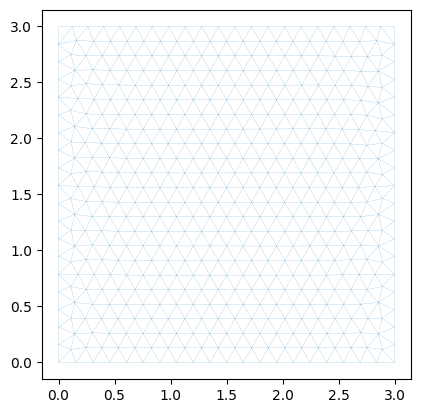

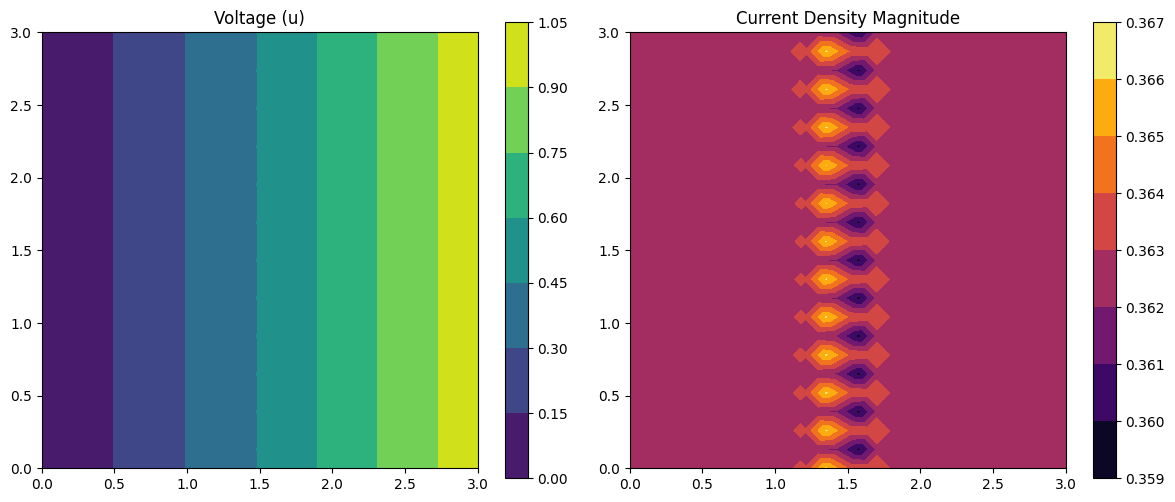

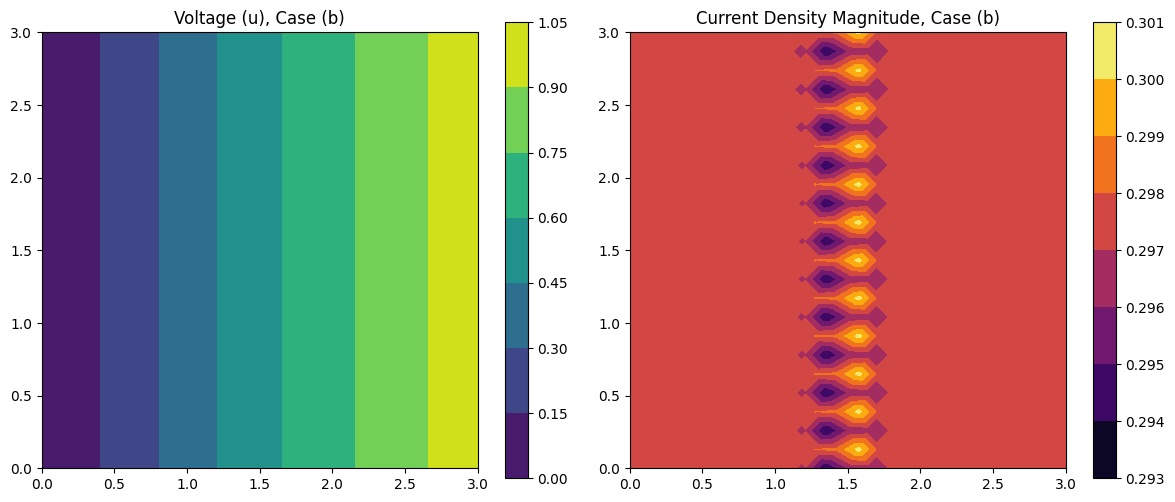

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.tri as mtri

L = 3.0
h0 = L / 20

bbox = [0, 3, 0, 3]

M = 20
pfix_left = np.column_stack((np.zeros(M), np.linspace(0, 3, M)))
pfix_right = np.column_stack((3 * np.ones(M), np.linspace(0, 3, M)))
pfix = np.vstack((pfix_left, pfix_right))

pts, tri = distmesh2D(fd, huniform, h0, bbox, pfix)

a1_val = 1.2
a2_val = 1.0
elem_a = elem_conductivity(tri, pts, a1_val, a2_val)

tol = 1e-8
fixed_nodes = {}
for i, p in enumerate(pts):
    if np.abs(p[0]) < tol:
        fixed_nodes[i] = 0.0
    if np.abs(p[0] - L) < tol:
        fixed_nodes[i] = 1.0


def stima3(verts, a):
    Aux = np.ones((3, 3))
    Aux[1:3, :] = np.transpose(verts)
    rhs = np.zeros((3, 2))
    rhs[1, 0] = 1
    rhs[2, 1] = 1
    G = np.linalg.solve(Aux, rhs)
    M_local = 0.5 * np.linalg.det(Aux) * (G @ G.T)
    return a * M_local

Npts = pts.shape[0]
A_global = lil_matrix((Npts, Npts))
f_global = np.zeros(Npts)

for elem in tri:
    verts = pts[elem]
    a_elem = elem_a[tri.tolist().index(list(elem))]
    Ke = stima3(verts, a_elem)
    for i_local in range(3):
        for j_local in range(3):
            A_global[elem[i_local], elem[j_local]] += Ke[i_local, j_local]


A_global = A_global.tocsr()
for i, val in fixed_nodes.items():
    A_global[i, :] = 0
    A_global[i, i] = 1
    f_global[i] = val

u = spsolve(A_global, f_global)


elem_grad = np.zeros((tri.shape[0], 2))
elem_current = np.zeros((tri.shape[0], 2))

for i, elem in enumerate(tri):
    verts = pts[elem]
    x1, y1, x2, y2, x3, y3 = verts.flatten()
    A_elem = 0.5 * np.abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))
    b = np.array([y2 - y3, y3 - y1, y1 - y2])
    c = np.array([x3 - x2, x1 - x3, x2 - x1])
    grad_local = np.vstack([b, c]).T / (2 * A_elem)
    u_elem = u[elem]
    grad_u = grad_local.T @ u_elem
    elem_grad[i, :] = grad_u
    elem_current[i, :] = -elem_a[i] * grad_u

node_current = np.zeros((Npts, 2))
node_count = np.zeros(Npts)
for i in range(tri.shape[0]):
    for j in tri[i, :]:
        node_current[j, :] += elem_current[i, :]
        node_count[j] += 1
node_current /= node_count[:, None]

triang = mtri.Triangulation(pts[:, 0], pts[:, 1], tri)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.tricontourf(triang, u, cmap='viridis')
plt.title('Voltage (u)')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
current_mag = np.sqrt(np.sum(node_current**2, axis=1))
plt.tricontourf(triang, current_mag, cmap='inferno')
plt.title('Current Density Magnitude')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()


a1_val = 0.8
a2_val = 1.0
elem_a = elem_conductivity(tri, pts, a1_val, a2_val)

A_global = lil_matrix((Npts, Npts))
f_global = np.zeros(Npts)
for elem in tri:
    verts = pts[elem]
    a_elem = elem_a[tri.tolist().index(list(elem))]
    Ke = stima3(verts, a_elem)
    for i_local in range(3):
        for j_local in range(3):
            A_global[elem[i_local], elem[j_local]] += Ke[i_local, j_local]
A_global = A_global.tocsr()
for i, val in fixed_nodes.items():
    A_global[i, :] = 0
    A_global[i, i] = 1
    f_global[i] = val

u_b = spsolve(A_global, f_global)

elem_grad = np.zeros((tri.shape[0], 2))
elem_current = np.zeros((tri.shape[0], 2))
for i in range(tri.shape[0]):
    elem_indices = tri[i, :]
    verts = pts[elem_indices, :]
    x1, y1 = verts[0]
    x2, y2 = verts[1]
    x3, y3 = verts[2]
    A_elem = 0.5 * np.abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))
    b = np.array([y2 - y3, y3 - y1, y1 - y2])
    c = np.array([x3 - x2, x1 - x3, x2 - x1])
    grad_local = np.zeros((3, 2))
    for j in range(3):
        grad_local[j, :] = np.array([b[j], c[j]]) / (2 * A_elem)
    u_elem = u_b[elem_indices]
    grad_u = grad_local.T @ u_elem
    elem_grad[i, :] = grad_u
    elem_current[i, :] = -elem_a[i] * grad_u

node_current = np.zeros((Npts, 2))
node_count = np.zeros(Npts)
for i in range(tri.shape[0]):
    for j in tri[i, :]:
        node_current[j, :] += elem_current[i, :]
        node_count[j] += 1
node_current /= node_count[:, None]

triang = mtri.Triangulation(pts[:, 0], pts[:, 1], tri)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.tricontourf(triang, u_b, cmap='viridis')
plt.title('Voltage (u), Case (b)')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
current_mag_b = np.sqrt(np.sum(node_current**2, axis=1))
plt.tricontourf(triang, current_mag_b, cmap='inferno')
plt.title('Current Density Magnitude, Case (b)')
plt.colorbar()
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()
